This is the code that makes up the skew-t log(p) plots for Zexuan's WRF model output

In [2]:
#Packages that may be needed but I'm not 100% sure
#importing functions that are used to predict dewpoint and temperature
import pyart
import act
import glob
import matplotlib.pyplot as plt
import xarray 
from datetime import datetime
from matplotlib.dates import DateFormatter
import numpy as np
import metpy
import wrf
from wrf import td
from wrf import tk
from PIL import Image as img

import warnings

# Import third party libraries
import matplotlib.pyplot as plt
import metpy
import metpy.calc as mpcalc
from metpy.plots import SkewT
from metpy.units import units
import numpy as np
import scipy

from copy import deepcopy

# Import Local Libs
from act.utils import datetime_utils as dt_utils
from act.plotting import Display,SkewTDisplay


## You are using the Python ARM Radar Toolkit (Py-ART), an open source
## library for working with weather radar data. Py-ART is partly
## supported by the U.S. Department of Energy as part of the Atmospheric
## Radiation Measurement (ARM) Climate Research Facility, an Office of
## Science user facility.
##
## If you use this software to prepare a publication, please cite:
##
##     JJ Helmus and SM Collis, JORS 2016, doi: 10.5334/jors.119



In [4]:
class SkewTDisplayWRF(SkewTDisplay):        
    def __init__(self, obj):
        super().__init__(obj)
                         
    def plot_from_u_and_v_wrf(
        self,
        u_field,
        v_field,
        p_field,
        pb_field,
        t_field,
        qv_field,
        lat_id,
        lon_id,
        dsname=None,
        subplot_index=(0,),
        p_levels_to_plot=None,
        show_parcel=True,
        shade_cape=True,
        shade_cin=True,
        set_title=None,
        smooth_p=3,
        plot_barbs_kwargs=dict(),
        plot_kwargs=dict(), ):

        if dsname is None and len(self._obj.keys()) > 1:
            raise ValueError(
                'You must choose a datastream when there are 2 '
                'or more datasets in the TimeSeriesDisplay '
                'object.'
            )
        elif dsname is None:
            dsname = list(self._obj.keys())[0]

        if p_levels_to_plot is None:
            p_levels_to_plot = np.array(
                [
                    50.0,
                    100.0,
                    200.0,
                    300.0,
                    400.0,
                    500.0,
                    600.0,
                    700.0,
                    750.0,
                    800.0,
                    850.0,
                    900.0,
                    950.0,
                    1000.0,
                ])* units('hPa')

        # Get pressure and smooth if not in order
        
        p = self._obj[dsname][p_field][0,:,lat_id, lon_id]
        p_units = self._obj[dsname][p_field].attrs['units']
        p = p.values
    
        pb = self._obj[dsname][pb_field][0,:,lat_id, lon_id]
        pb = pb.values
        p = (p + pb)
        # It seems that it used hPa unit all the time so let's convert it to hPa
        # p = (p + pb)/100
        # p = p * getattr(units, 'hPa')
        
        T = self._obj[dsname][t_field][0,:,lat_id, lon_id]
        T = T.values 
        
        qv = self._obj[dsname][qv_field][0,:,lat_id, lon_id]
        qv = qv.values
        
        T = wrf.tk(p, T+300)-273.15
        Td = wrf.td(p/100, qv)
            
        p = p/100
        p = p * getattr(units, 'hPa')
        
        T_units = 'degC'
        Td_units = 'degC'
        
        T = T.values * getattr(units, T_units)
        Td = Td.values * getattr(units, T_units)

        u = self._obj[dsname][u_field][0,:,lat_id, lon_id]
        u_units = self._obj[dsname][u_field].attrs['units']
        u = u.values * getattr(units, u_units)

        v = self._obj[dsname][v_field][0,:,lat_id, lon_id]
        v_units = self._obj[dsname][v_field].attrs['units']
        v = v.values * getattr(units, v_units)

        u_red = np.zeros_like(p_levels_to_plot) * getattr(units, u_units)
        v_red = np.zeros_like(p_levels_to_plot) * getattr(units, v_units)

        # Check p_levels_to_plot units, and convert to p units if needed
        if not hasattr(p_levels_to_plot, 'units'):
            p_levels_to_plot = p_levels_to_plot * getattr(units, p_units)
        else:
            p_levels_to_plot = p_levels_to_plot.to(p_units)
            
        for i in range(len(p_levels_to_plot)):
            index = np.argmin(np.abs(p_levels_to_plot[i] - p))
            u_red[i] = u[index].magnitude * getattr(units, u_units)
            v_red[i] = v[index].magnitude * getattr(units, v_units)
            
        self.SkewT[subplot_index].plot(p, T, 'r', **plot_kwargs)
        self.SkewT[subplot_index].plot(p, Td, 'g', **plot_kwargs)
        self.SkewT[subplot_index].plot_barbs(p_levels_to_plot.magnitude, u_red, v_red, **plot_barbs_kwargs)
        
        # Metpy fix if Pressure does not decrease monotonically in
        # your sounding.
        try:
            prof = mpcalc.parcel_profile(p, T[0], Td[0]).to('degC')
        except metpy.calc.exceptions.InvalidSoundingError:
            p = scipy.ndimage.median_filter(p, 3, output=float)
            p = metpy.units.units.Quantity(p, p_units)
            prof = mpcalc.parcel_profile(p, T[0], Td[0]).to('degC')

        if show_parcel:
            # Only plot where prof > T
            lcl_pressure, lcl_temperature = mpcalc.lcl(p[0], T[0], Td[0])
            self.SkewT[subplot_index].plot(lcl_pressure, lcl_temperature, 'ko', markerfacecolor='black', **plot_kwargs)
            self.SkewT[subplot_index].plot(p, prof, 'k', linewidth=2, **plot_kwargs)

        if shade_cape:
            self.SkewT[subplot_index].shade_cape(p, T, prof, linewidth=2)

        if shade_cin:
            self.SkewT[subplot_index].shade_cin(p, T, prof, linewidth=2)

        # Set Title
        # if set_title is None:
        #     set_title = ' '.join(
        #         [
        #             dsname,
        #             'on',
        #             dt_utils.numpy_to_arm_date(self._obj[dsname].Times.values[0]),
        #         ])

        self.axes[subplot_index].set_title(set_title)

        # Set Y Limit
        our_data = p.magnitude
        if np.isfinite(our_data).any():
            yrng = [np.nanmax(our_data), np.nanmin(our_data)]
        else:
            yrng = [1000.0, 100.0]
        self.set_yrng(yrng, subplot_index)

        # Set X Limit
        xrng = [np.nanmin(T.magnitude) - 10.0, np.nanmax(T.magnitude) + 10.0]
        self.set_xrng(xrng, subplot_index)

        return self.axes[subplot_index]        

/global/homes/l/laart/.conda/envs/pyart_env/lib/python3.8/site-packages/act/plotting/plot.py:80: UserWarning: Could not discern datastreamname and dict or tuple were not provided. Using defaultname of act_datastream!
  warnings.warn(


NameError: name 'U' is not defined

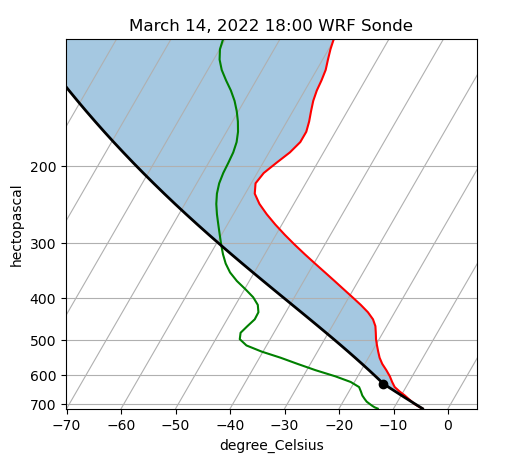

In [8]:
#Trial run/ Code to make one plot
t=xarray.open_dataset("/project/projectdirs/m4099/gsharing/bsu_cfsr_rad22_data/6HRLY_OUTPUT/wrfout_d03_2022-03-14_18:00:00")
SkewT = SkewTDisplayWRF(t)
SkewT.plot_from_u_and_v_wrf('U', 'V', 'P', 'PB', 'T', 'QVAPOR', 124, 109,set_title="March 14, 2022 18:00 WRF Sonde")
 

In [3]:
#Loop to make plots
directory = '/project/projectdirs/m4099/gsharing/bsu_cfsr_rad22_data/6HRLY_OUTPUT/'
from pathlib import Path

# files = Path(directory).glob('*')
files = Path(directory).glob('*12:00:00*')
for file in files:
    f = xarray.open_dataset(file)
    SkewT = SkewTDisplayWRF(f)
    SkewT.plot_from_u_and_v_wrf('U', 'V', 'P', 'PB', 'T', 'QVAPOR', 124, 109, set_title='SkewT plot '+str(file)[-19:])
    print(file)
    plt.savefig('/global/cscratch1/sd/laart/wrf_sonde_'+str(file)[-19:]+'.png')
    plt.show()
    #break
    

NameError: name 'SkewTDisplayWRF' is not defined